# Exercise 2
#### Lars Kühmichel, Ergin Kohen Sagner, Nicolas Wolf

## 3 Data Preparation

We want $\frac{train}{test} = \frac{3}{2}$ and $train + test = 1$, ergo $test = 0.4$.

In [674]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection

from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# filter to 1s and 7s
os = np.logical_or(target==1, target==7)
data17 = data[os]
images17 = images[os]
target17 = target[os]

# for convenience, also define data1, data7, etc.
o = target == 1
data1 = data[o]
images1 = images[o]
target1 = target[o]

s = target == 7
data7 = data[s]
images7 = images[s]
target7 = target[s]


del o
del s
del os

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    data17, target17, test_size=0.4, random_state=0
)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


### 3.1 Dimension Reduction

In theory, it would be a good idea to select features based on
the Fourier Transform of the data, since high frequencies are responsible
for the shape of the digit and we could thus reduce the dimensionality
of the data. However, we have found no significantly
defining feature in the FT from the plots (and some experimentation).
It is thus a better idea to select pixels from the original (untransformed) data.

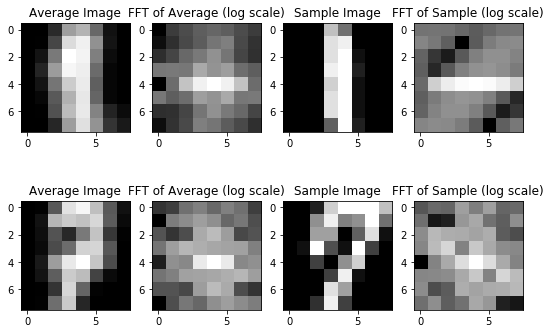

(216, 2)


In [675]:
digits = [1, 7]
n = len(digits)

fig, axes = plt.subplots(n, 4, figsize=(9, 3 * n))

for i, d in enumerate(digits):
    keep = target == d
    keep_images = images[keep]

    avg_img = np.mean(keep_images, axis=0)
    sample_img = keep_images[np.random.choice(keep_images.shape[0]), :, :]
    avg_fft = np.fft.fftshift(
        np.log(np.abs(np.fft.fft2(avg_img)) ** 2)
    )
    sample_fft = np.fft.fftshift(
        np.log(np.abs(np.fft.fft2(sample_img)) ** 2)
    )


    axes[i][0].imshow(avg_img, cmap="gray")
    axes[i][0].set_title("Average Image")
    axes[i][1].imshow(avg_fft, cmap="gray")
    axes[i][1].set_title("FFT of Average (log scale)")
    axes[i][2].imshow(sample_img, cmap="gray")
    axes[i][2].set_title("Sample Image")
    axes[i][3].imshow(sample_fft, cmap="gray")
    axes[i][3].set_title("FFT of Sample (log scale)")


plt.show()


def feature1(x):
    # pixel (2, 3) is brighter for ones
    idx = 2 * images.shape[1] + 3
    return x[:,idx]

def feature2(x):
    # pixel (7, 4) is also brighter for ones
    idx = 7 * images.shape[1] + 4
    return x[:, idx]


def reduce_dimensions(x):
    return np.stack([feature1(x), feature2(x)], axis=1)


reduced_x = reduce_dimensions(x_train)

print(reduced_x.shape)

### 3.2 Scatterplot

The features we chose do not overlap significantly

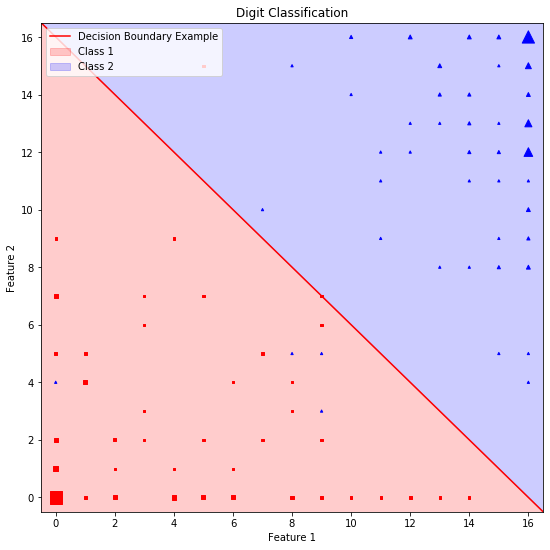

In [676]:
def line(x):
    return 16 - x

line_x = np.linspace(-5, 20, 1000)
line_y = line(line_x)

plt.figure(figsize=(9, 9))
plt.fill_between(line_x, -5, line_y, alpha=0.2, label="Class 1", color="red")
plt.fill_between(line_x, line_y, 20, alpha=0.2, label="Class 2", color="blue")

unique1, counts1 = np.unique(reduced_x.T[:,y_train==1], axis=1, return_counts=True)
unique7, counts7 = np.unique(reduced_x.T[:,y_train==7], axis=1, return_counts=True)

plt.plot(line_x, line_y, label="Decision Boundary Example", color="red")
plt.scatter(unique1[0], unique1[1], s=5 * counts1, marker="^", color="blue")
plt.scatter(unique7[0], unique7[1], s=5 * counts7, marker="s", color="red")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(-0.5, 16.5)
plt.ylim(-0.5, 16.5)
plt.title("Digit Classification")
plt.legend(loc="upper left")

plt.show()

## 4 Nearest Mean
### 4.1 Implement the nearest mean classifier

In [677]:
from scipy.spatial import distance

training_features = reduce_dimensions(x_train)
training_labels = y_train
test_features = reduce_dimensions(x_test)
test_labels = y_test


class NearestMeanClassifier:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

        # save unique labels and their respective feature-space centroids
        self.ulabels = np.unique(self.labels)
        self.centroids = np.array([np.mean(self.features[self.labels == l], axis=0)
                                   for l in self.ulabels])

    def distances(self, data):
        """
        Calculate the distance from each feature to every centroid and return as matrix
        For n unique centroids and m instances in data,
        this returns a matrix of shape n x m
        """
        diff = self.centroids[np.newaxis,] - data[:,np.newaxis]
        return np.linalg.norm(diff, axis=-1)


    def predict(self, data):
        distances = self.distances(data)
        # return the label for the centroid with least distance
        return self.ulabels[np.argmin(distances, axis=-1)]


nmc = NearestMeanClassifier(training_features, training_labels)

predictions = nmc.predict(test_features)

# check error rate
incorrect = predictions != test_labels
error = np.sum(incorrect) / len(incorrect)
print(f"Error rate: {error:.2f}")








Error rate: 0.01


### 4.2 Visualize the decision regions

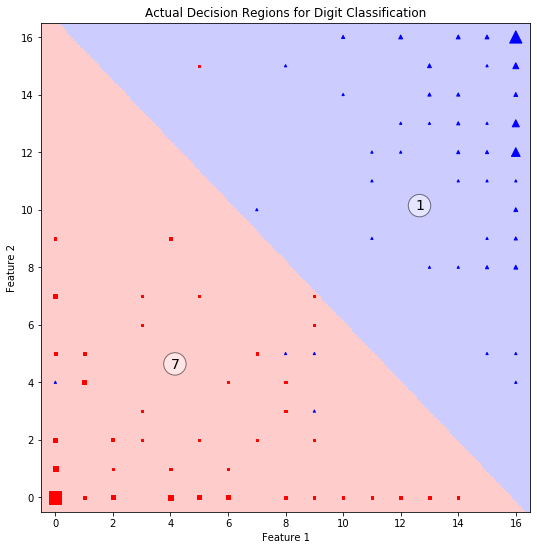

In [678]:
n = 500
extent = [-5, 20]
x = y = np.linspace(*extent, n)
xy = np.stack(np.meshgrid(x, y), axis=-1)

plot_data = nmc.predict(np.reshape(xy, (n ** 2, 2))).reshape((n, n))

plt.figure(figsize=(9, 9))

plt.imshow(plot_data, extent=2 * extent, origin="lower", cmap="bwr", alpha=0.2)
plt.scatter(unique1[0], unique1[1], s=5 * counts1, marker="^", color="blue")
plt.scatter(unique7[0], unique7[1], s=5 * counts7, marker="s", color="red")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(-0.5, 16.5)
plt.ylim(-0.5, 16.5)
bbox = {
    "boxstyle": "circle",
    "facecolor": "white",
    "alpha": 0.5
}
plt.text(4, 4.5, "7", fontsize=14, bbox=bbox)
plt.text(12.5, 10, "1", fontsize=14, bbox=bbox)
plt.title("Actual Decision Regions for Digit Classification")
plt.show()

## 5 QDA
### 5.1 Implement QDA Training & 5.2 Implement QDA Prediction

In [679]:
class QDAClassifier:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

        self.ulabels, counts = np.unique(self.labels, return_counts=True)
        self.filters = [self.labels == l for l in self.ulabels]

        self.filtered_features = [self.features[f] for f in self.filters]

        # mean of D dimensional features for C class labels => CxD
        self.mu = np.stack([np.mean(f, axis=0) for f in self.filtered_features])

        # DxD covariance matrix for the features for C class labels => CxDxD
        self.covmat = np.stack([np.cov(f, rowvar=False) for f in self.filtered_features])
        # precompute the inverse matrices and determinants
        self.icovmat = np.stack([np.linalg.inv(c) for c in self.covmat])
        # since covmats are always square, we can factor out the 2 * pi
        self.covdets = np.stack([(2 * np.pi) ** c.shape[0] * np.linalg.det(c) for c in self.covmat])

        # prior probabilities tell how often each class occurs => Cx1
        self.p = counts / len(self.labels)

    def fit(self):
        return self.mu, self.covmat, self.p

    def _b(self):
        return 0.5 * np.log(self.covdets) - np.log(self.p)

    def _mahalanobis(self, data):
        diff = data[:,np.newaxis,:] - self.mu[np.newaxis,:,:]

        prod = (diff[:,:,np.newaxis,:] * self.icovmat).sum(axis=3)
        return (prod * diff).sum(axis=2)

    def _distances(self, data):
        """ Squared Mahalanobis Distance """
        return self._mahalanobis(data) + self._b()


    def predict(self, data):
        return np.argmin(self._distances(data), axis=-1)

    def score(self, X_test, Y_test):
        predicted = self.predict(X_test)
        return 1 - (np.mean((predicted == 0) != (Y_test == 1)))

    def mvgauss(self, data):
        return np.exp(self._mahalanobis(data)) / np.sqrt(self.covdets)

    def get_params(self, deep=False):
        return {"mu": self.mu, "covmat": self.covmat, "p": self.p}



# turn 1s into 0s and 7s into 1s
training_labels = (training_labels == 7).astype(np.int32)
test_labels = (test_labels == 7).astype(np.int32)

qda = QDAClassifier(training_features, training_labels)

mu, covmat, p = qda.fit()

training_predictions = qda.predict(training_features)
test_predictions = qda.predict(test_features)

training_error = np.sum(training_predictions != training_labels) / training_labels.shape[0]
test_error = np.sum(test_predictions != test_labels) / test_labels.shape[0]

print(f"Training Error Rate: {training_error:.3f}")
print(f"Test Error Rate: {test_error:.3f}")


Training Error Rate: 0.023
Test Error Rate: 0.007


### 5.3 Visualization

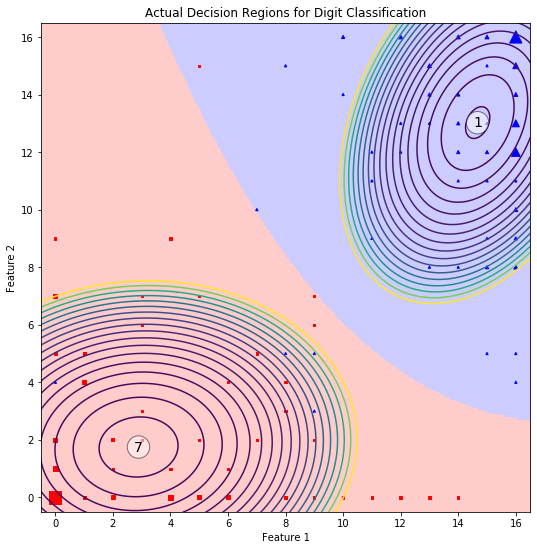

In [680]:
n = 500
extent = [-5, 20]
x = y = np.linspace(*extent, n)
xx, yy = np.meshgrid(x, y)
xy = np.stack([xx, yy]).reshape((n ** 2, 2))
xy = np.stack(np.meshgrid(x, y), axis=-1).reshape((n ** 2, 2))

plot_data = qda.predict(xy).reshape((n, n))
plot_contour_data = qda.mvgauss(xy)

plt.figure(figsize=(9, 9))

plt.imshow(plot_data, extent=2 * extent, origin="lower", cmap="bwr", alpha=0.2)

# contour_levels = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
contour_levels = np.logspace(-3, 0, 30)
plt.contour(xx, yy, plot_contour_data[:, 0].reshape((n, n)), extent=2 * extent, origin="lower", levels=contour_levels)
plt.contour(xx, yy, plot_contour_data[:, 1].reshape((n, n)), extent=2 * extent, origin="lower", levels=contour_levels)

plt.scatter(unique1[0], unique1[1], s=5 * counts1, marker="^", color="blue")
plt.scatter(unique7[0], unique7[1], s=5 * counts7, marker="s", color="red")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(-0.5, 16.5)
plt.ylim(-0.5, 16.5)
bbox = {
    "boxstyle": "circle",
    "facecolor": "white",
    "alpha": 0.5
}
plt.text(2.89, 1.75, "7", fontsize=14, bbox=bbox, horizontalalignment="center", verticalalignment="center")
plt.text(14.67, 13.02, "1", fontsize=14, bbox=bbox, horizontalalignment="center", verticalalignment="center")
plt.title("Actual Decision Regions for Digit Classification")
plt.show()



### 5.4 Performance evaluation

In [681]:
from sklearn.model_selection import cross_val_score
from uncertainties import ufloat

class CrossValQDA():
    def __init__(self, mu = None, covmat = None, p = None):
        self.mu = mu
        self.covmat = covmat
        self.p = p
        self.qda = None

    def fit(self, X_train, Y_train):
        self.qda = QDAClassifier(X_train, Y_train)
        self.mu, self.covmat, self.p = self.qda.fit()

    def score(self, X_test, Y_test):
        predicted = self.qda.predict(X_test)
        return 1 - (np.mean((predicted == 0) != (Y_test == 1)))

    def get_params(self, deep=False):
        return {"mu": self.mu, "covmat": self.covmat, "p": self.p}


cvqda = CrossValQDA()
scores = cross_val_score(cvqda, reduce_dimensions(data17), target17, cv=10)
print(scores)

score = ufloat(np.mean(scores), np.std(scores))
error = 1 - score

print(f"score = {score}")
print(f"error = {error}")


[0.97297297 0.88888889 1.         0.97222222 1.         1.
 1.         0.97222222 1.         1.        ]
score = 0.981+/-0.033
error = 0.019+/-0.033


## 6 LDA

In [682]:
def predict_lda2(mu, Sigma_w, b, test_features):
    # mu.shape = 2 x D
    # Sigma_w.shape = 2 x D x D
    # b.shape = 1
    # test_features.shape = M x D

    w = (mu[1] - mu[0]).dot(np.linalg.inv(Sigma_w))

    res = np.dot(w, test_features.T) + b
    return (res > 0).astype(int)

(2, 2) (2, 2)
[[14.67479675 13.02439024]
 [ 2.89247312  1.75268817]] 

[[9.24035463 1.6504745 ]
 [1.6504745  9.2048086 ]] 

17.726699671743027


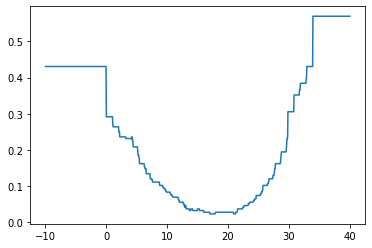

In [683]:
def fit_lda2(training_features, training_labels):
    # training_features.shape = N x D
    # training_labels.shape = N
    # N=#instances, D=#features (=2)

    # mu.shape = 2 x D
    # covmat.shape = 2 x D x D
    # covmat.shape = D x D
    # p.shape = 2

    mu = np.array([np.mean(training_features[training_labels == label,:], axis=0) for label in np.unique(training_labels)])

    d = training_features - mu[(training_labels == 7).astype(int)]
    Sigma_w = d[:,None,:]*d[:,:,None]
    Sigma_w = np.sum(Sigma_w, axis=0) / training_features.shape[0]


    # minimize training error wrt b
    def predict_lda_minimize(b, mu_, Sigma_w_, X_train_, Y_train_):
        predicted = predict_lda2(mu_, Sigma_w_, b, X_train_)
        return np.mean((predicted == 0) != (Y_train_ == 1))

    from scipy.optimize import minimize_scalar
    res = minimize_scalar(predict_lda_minimize, bounds=(-10,40), method='bounded', args=(mu, Sigma_w, training_features, training_labels))
    b = res.x

    return mu, Sigma_w, b


mu, Sigma_w, b = fit_lda2(reduced_x, y_train)
print(mu.shape, Sigma_w.shape)
print(mu, "\n")
print(Sigma_w, "\n")
print(b)


def predict_lda_minimize(b, mu_, Sigma_w_, X_train_, Y_train_):
    predicted = predict_lda2(mu_, Sigma_w_, b, X_train_)
    return np.mean((predicted == 0) != (Y_train_ == 1))
x = np.linspace(-10,40, 1000)
y = [predict_lda_minimize(x_, mu, Sigma_w, reduced_x, y_train) for x_ in x]
plt.plot(x, y)

In [684]:
predicted = predict_lda2(mu, Sigma_w, b, reduce_dimensions(x_test))
print(f"test error = \t{np.mean((predicted == 0) != (y_test == 1))}")


predicted = predict_lda2(mu, Sigma_w, b, reduce_dimensions(x_train))
print(f"train error = \t{np.mean((predicted == 0) != (y_train == 1))}")

test error = 	0.006896551724137931
train error = 	0.023148148148148147


In [685]:
from sklearn.model_selection import cross_val_score

class LDA_Classifier():
    def __init__(self, mu = None, Sigma_w = None, b = None):
        self.mu = mu
        self.Sigma_w = Sigma_w
        self.b = b

    def fit(self, X_train, Y_train):
        self.mu, self.Sigma_w, self.b = fit_lda2(X_train, Y_train)

    def score(self, X_test, Y_test):
        predicted = predict_lda2(self.mu, self.Sigma_w, self.b, X_test)
        return 1 - (np.mean((predicted == 0) != (Y_test == 1)))

    def get_params(self, deep=False):
        return {"mu": self.mu, "Sigma_w": self.Sigma_w, "b": self.b}

lda_classifier = LDA_Classifier()
scores = cross_val_score(lda_classifier, reduce_dimensions(data17), target17, cv=10)
print(scores)
print(f"score = {np.mean(scores):0.3f} +- {np.std(scores):0.3f}")
print(f"error = {1-np.mean(scores):0.3f} +- {np.std(scores):0.3f}")


[0.97297297 0.91666667 1.         0.97222222 1.         1.
 1.         0.97222222 1.         1.        ]
score = 0.983 +- 0.025
error = 0.017 +- 0.025


(200, 200, 2)
(200, 200)
(200, 200)


No handles with labels found to put in legend.


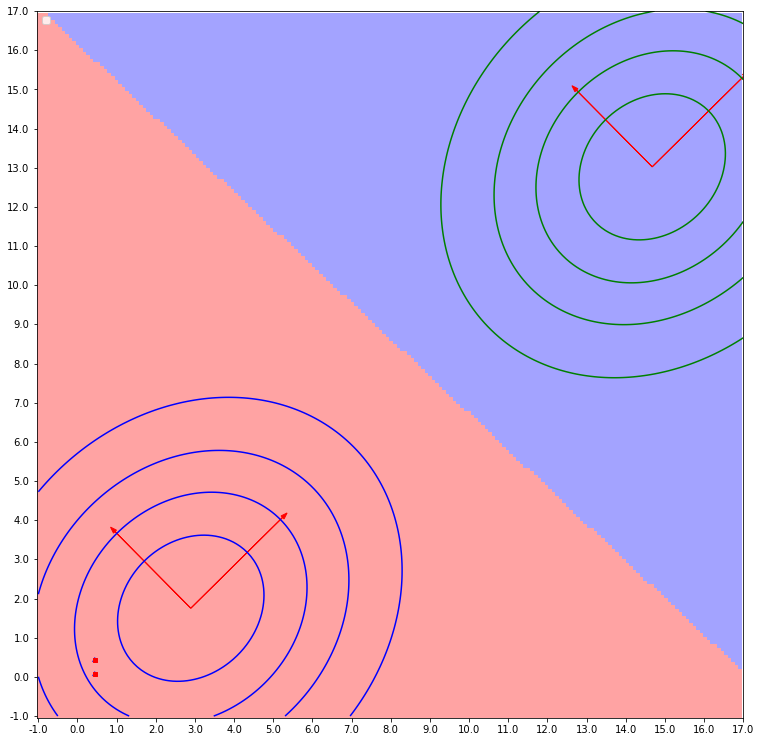

In [686]:
plt.figure(figsize=(13,13))

mu, Sigma_w, b = fit_lda2(reduced_x, y_train)


grid = np.array(np.meshgrid(np.linspace(-1,17,200), np.linspace(-1,17,200)))
grid = np.moveaxis(grid, 0, -1)
print(grid.shape)

Sigma_w_inverse = np.linalg.inv(Sigma_w)
Sigma_w_det = np.linalg.det(Sigma_w)
N = 1 / (np.sqrt((2*np.pi)**2)*Sigma_w_det)

for k, color in enumerate(["green", "blue"]):

    diff = grid - mu[k]

    prod = (diff[:,:,np.newaxis,:] * Sigma_w_inverse).sum(axis=3)
    exponent = -0.5 * (prod * diff).sum(axis=2)

    zi = N * np.exp(exponent)
    print(zi.shape)

    xi, yi = np.meshgrid(np.linspace(0,200,200), np.linspace(0,200,200))
    CS = plt.contour(xi, yi, zi, 5, linewidths=1.5, colors=color)




data = []
grid = np.array(np.meshgrid(np.linspace(-1,17,200), np.linspace(-1,17,200)))
for i in range(200):
    data.append(predict_lda2(mu, Sigma_w, b, grid[:,:,i].T))

reduced_x_train = reduce_dimensions(x_train)

unique1, count1 = np.unique(reduced_x[y_train == 1,:], axis=1, return_counts=True)
unique7, count7 = np.unique(reduced_x[y_train == 1,:], axis=1, return_counts=True)

plt.imshow(np.array(data), interpolation="nearest", origin="lower", cmap="bwr", alpha=0.2)
plt.scatter(unique1[0], unique1[1], s=15 * count1, color="blue", marker="^")
plt.scatter(unique7[0], unique7[1], s=15 * count7, color="red", marker="s")

# unique_x_train_1, count_x_train_1 = np.unique(reduced_x_train[y_train == 1,:], axis=1, return_counts=True)
# unique_x_train_7, count_x_train_7 = np.unique(reduced_x_train[y_train == 7,:], axis=1, return_counts=True)

plt.imshow(np.array(data), interpolation='nearest', origin='lower', cmap="bwr", alpha=0.2)
# plt.scatter((unique_x_train_1[0]+1)*200./18, (unique_x_train_1[1]+1)*200./18, s=15*count_x_train_1, color="green", marker="o", label="Class 1")
# plt.scatter((unique_x_train_7[0]+1)*200./18, (unique_x_train_7[1]+1)*200./18, s=15*count_x_train_7, color="blue", marker="s", label="Class 7")
plt.xticks(np.linspace(0,200,19), np.linspace(-1,17,19))
plt.yticks(np.linspace(0,200,19), np.linspace(-1,17,19))


#print(mu[0])
for mu_k in mu:
    eigenvalues, eigenvector = np.linalg.eig(Sigma_w)
    scaled_eigenvectors = eigenvector * np.sqrt(eigenvalues)
    #print(scaled_eigenvectors)

    plt.arrow(*((mu_k+1)*200./18), *(scaled_eigenvectors.T[0]*200./18), color="red", head_width=1.2)
    plt.arrow(*((mu_k+1)*200./18), *(scaled_eigenvectors.T[1]*200./18), color="red", head_width=1.2)



plt.legend(loc="upper left")